In [1]:
import os
os.chdir("..")

from utils.losses import *
from utils.helpers import *
from utils.data_generator import DatasetGenerator
from utils.utils import *
from functools import partial

import configargparse
import matplotlib.pyplot as plt

In [2]:
input_training = r"C:\Users\pso9kor\Datasets\serm\0.SeRM_image\train"
label_training = r"C:\Users\pso9kor\Datasets\serm\0.SeRM_image\trainannot"
max_samples_training = 10000
label_file = r"config\serm_labels.py"
num_classes = 17
image_size = (384, 384)
augment = True
resize = False
shuffle = True
batch_size = 4
epochs = 10

In [3]:
# determine absolute filepaths
input_training = abspath(input_training)
label_training = abspath(label_training)
print(input_training, label_training)

# get class names and class colors by parsing the labels py file
class_names, class_colors, class_ids = get_labels(parse_convert_py(label_file))
class_ids_color = [list(np.ones(3).astype(int)*k) for k in class_ids]
assert num_classes == len(class_colors)

print("Number of classes - ", len(class_colors))
for id, name, color, id_color in zip(class_ids, class_names, class_colors, class_ids_color):
    print(f"{id} - {name} - {color} - {id_color}")

C:\Users\pso9kor\Datasets\serm\0.SeRM_image\train C:\Users\pso9kor\Datasets\serm\0.SeRM_image\trainannot
Number of classes -  17
0 - Background - [0, 0, 0] - [0, 0, 0]
1 - Slow down - [0, 0, 255] - [1, 1, 1]
2 - Go ahead - [0, 128, 255] - [2, 2, 2]
3 - Turn right - [255, 128, 0] - [3, 3, 3]
4 - Turn left - [255, 192, 64] - [4, 4, 4]
5 - Ahead or turn right - [64, 0, 255] - [5, 5, 5]
6 - Ahead or turn left - [128, 0, 255] - [6, 6, 6]
7 - Crosswalk - [255, 0, 255] - [7, 7, 7]
8 - Double line (yellow) - [0, 255, 0] - [8, 8, 8]
9 - Double line (blue) - [192, 255, 128] - [9, 9, 9]
10 - Broken line (white) - [210, 210, 210] - [10, 10, 10]
11 - Single line (yellow) - [255, 255, 0] - [11, 11, 11]
12 - Single line (white) - [128, 128, 128] - [12, 12, 12]
13 - Stop line - [255, 0, 0] - [13, 13, 13]
14 - Numbers - [64, 192, 64] - [14, 14, 14]
15 - Texts - [128, 192, 128] - [15, 15, 15]
16 - Others - [128, 64, 80] - [16, 16, 16]


In [4]:
# list files
image_path = get_files_recursive(input_training)
label_path = get_files_recursive(label_training)
_, ids = sample_list(label_path, n_samples=1000)
image_path = np.take(image_path, ids)
label_path = np.take(label_path, ids)
data_path_ds = tf.data.Dataset.from_tensor_slices((image_path, label_path))

# load files
def load_data(image_path, label_path):
    image = load_image_op(image_path)
    label = load_image_op(label_path)
    return image, label

In [17]:
dataset = data_path_ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

for e, i in enumerate(dataset):
    print(e)
    print(len(i))
    for k in i:
        print(type(k), k.shape)
    image = i[0]
    label = i[1]
    break

0
2
<class 'tensorflow.python.framework.ops.EagerTensor'> (320, 1280, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (320, 1280, 3)


In [18]:
def get_augmentations(image_size):
    return A.Compose([
        A.OneOf(
            [
                A.Resize(image_size[0], image_size[1]),
                A.RandomSizedCrop(min_max_height=(int(image_size[0]*0.5), int(image_size[0]*0.8)),
                                  height=image_size[0],
                                  width=image_size[1]),
            ], p=1),
        A.CoarseDropout(),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.HueSaturationValue(hue_shift_limit=100, val_shift_limit=0)
        ])

def augment_func(image, label, image_size):
    """Customizable augmentation using Albumentations library."""
    """Set always_apply to instantiate transform as a
    preprocess transformation."""
    transforms = get_augmentations(image_size)
    
    # Converting image to tf.float32 type
    """Albumentations augmentation functions only supports
    .uint8 and .float32 data types therefore conversion is
    required."""
    image = tf.cast(x=image, dtype=tf.uint8).numpy()
    label = tf.cast(x=label, dtype=tf.uint8).numpy()

    # Apply augmentation on each image instance
    """transforms function is an Albumentations Compose()
    function that outputs a dictionary in a form of 
    {'image': image}, and image is in uint8 form."""
    augment = transforms(image=image, mask=label)
    image = augment['image']
    label = augment['mask']

    return image, label

In [19]:
def augment(image, label):
    """Function is formulated to convert the image and label
    from a numpy array to a tf numpy array."""
    image, label = tf.numpy_function(func=augment_func, 
                                        inp=[image, label, image_size],
                                        Tout=[tf.uint8, tf.uint8])
    return image, label

def set_shapes(image, label):
    image.set_shape(image_size + (3,))
    label.set_shape(image_size + (3,))
    return image, label        

def resize(image, label):
    image = resize_image_op(image, image_size)
    label = resize_image_op(label, image_size)
    return image, label

def normalize_n_one_hot(image, label):
    image = normalize_image_op(image)
    label = one_hot_encode_op(label, class_ids_color)
    return image, label

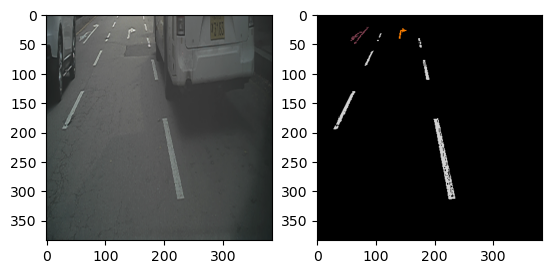

In [34]:
img, lbl = augment(image, label)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(decode_gray_index(cv2.cvtColor(resize_image_op(lbl, image_size).numpy(), cv2.COLOR_BGR2GRAY), class_colors))

In [35]:
dataset_aug = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
dataset_aug = dataset_aug.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

for e, i in enumerate(dataset_aug):
    print(e)
    print(len(i))
    for k in i:
        print(type(k), k.shape)
    img1 = i[0]
    lbl1 = i[1]        
    break

0
2
<class 'tensorflow.python.framework.ops.EagerTensor'> (384, 384, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (384, 384, 3)


In [36]:
lbl1.shape, np.unique(lbl1), lbl1[100][100], one_hot_encode_op(lbl1, class_ids_color)[100][100]

(TensorShape([384, 384, 3]),
 array([ 0,  3, 10, 16], dtype=uint8),
 <tf.Tensor: shape=(3,), dtype=uint8, numpy=array([0, 0, 0], dtype=uint8)>,
 <tf.Tensor: shape=(17,), dtype=float32, numpy=
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>)

In [37]:
np.unique(decode_one_hot_op(one_hot_encode_op(lbl1, class_ids_color), class_colors))

array([  0,  64,  80, 128, 210, 255])

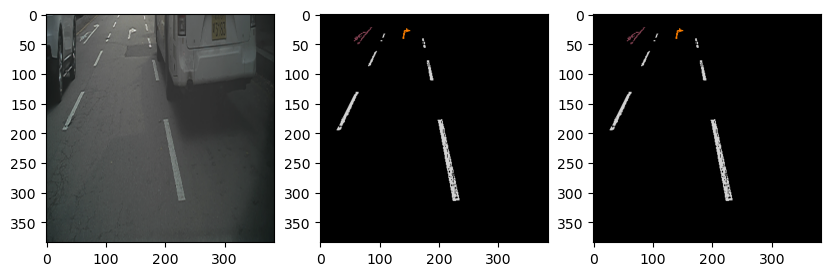

In [39]:
plt.figure(figsize=(10,12))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(decode_gray_index(cv2.cvtColor(lbl1.numpy(), cv2.COLOR_BGR2GRAY), class_colors))
plt.subplot(1, 3, 3)
plt.imshow(decode_one_hot_op(one_hot_encode_op(lbl1, class_ids_color), class_colors))

In [42]:
dataset_nh = dataset_aug.map(normalize_n_one_hot, num_parallel_calls=tf.data.AUTOTUNE)

for e, i in enumerate(dataset_nh):
    print(e)
    print(len(i))
    for k in i:
        print(type(k), k.shape)
    img2 = i[0]
    lbl2 = i[1]
    break

0
2
<class 'tensorflow.python.framework.ops.EagerTensor'> (384, 384, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> (384, 384, 17)


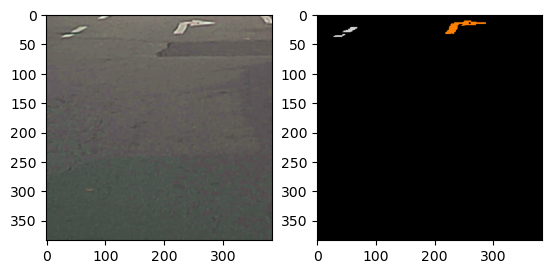

In [43]:
plt.subplot(1, 2, 1)
plt.imshow(img2)
plt.subplot(1, 2, 2)
plt.imshow(decode_one_hot_op(lbl2, class_colors))

In [44]:
dataset_f = dataset_nh.shuffle(buffer_size=4*100)
dataset_f = dataset_f.batch(4, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
dataset_f = dataset_f.repeat(10)
dataset_f = dataset_f.prefetch(tf.data.AUTOTUNE)

len(dataset_f), dataset_f

(2500,
 <PrefetchDataset element_spec=(TensorSpec(shape=(4, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 384, 384, 17), dtype=tf.float32, name=None))>)

0
2


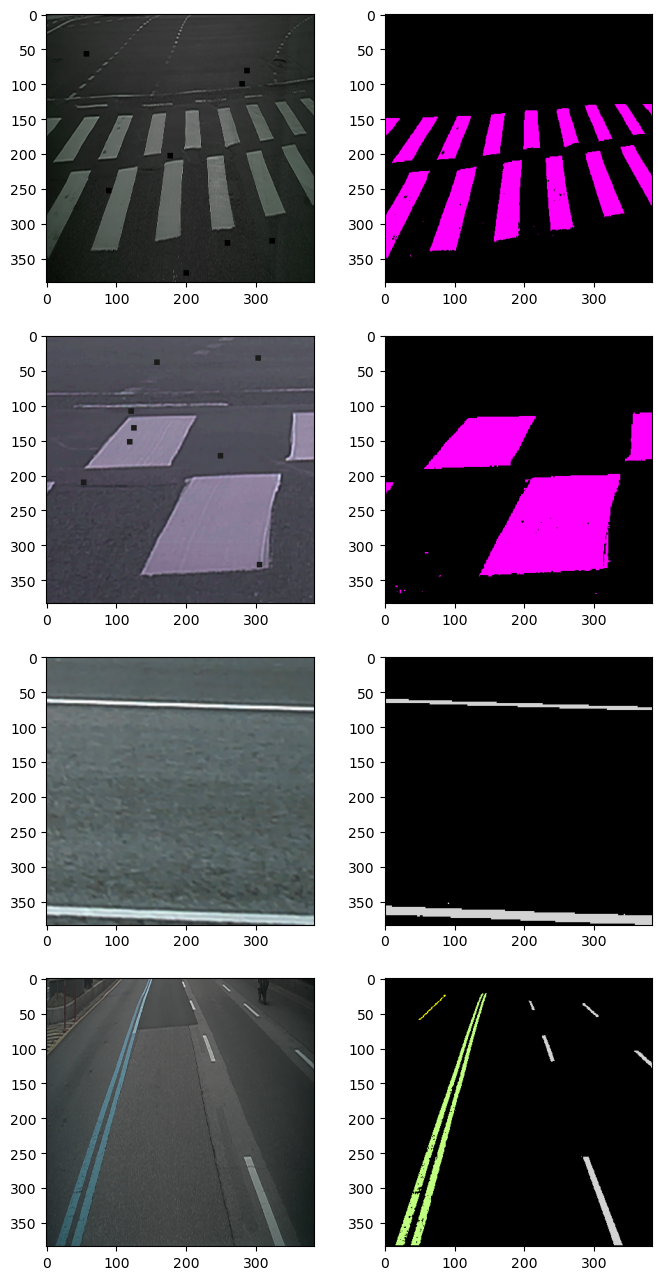

In [45]:
r, c = 4, 2
plt.figure(figsize=(r*2,c*8))
for e, i in enumerate(dataset_f):
    print(e)
    print(len(i))
    plt.subplot(r, c, 1)
    plt.imshow(i[0][0])
    plt.subplot(r, c, 2)
    plt.imshow(decode_one_hot_op(i[1][0], class_colors))
    plt.subplot(r, c, 3)
    plt.imshow(i[0][1])
    plt.subplot(r, c, 4)
    plt.imshow(decode_one_hot_op(i[1][1], class_colors))
    plt.subplot(r, c, 5)
    plt.imshow(i[0][2])
    plt.subplot(r, c, 6)
    plt.imshow(decode_one_hot_op(i[1][2], class_colors))
    plt.subplot(r, c, 7)
    plt.imshow(i[0][3])
    plt.subplot(r, c, 8)
    plt.imshow(decode_one_hot_op(i[1][3], class_colors))
    break

In [50]:
trainGen = DatasetGenerator(data_path=(input_training, label_training),
                            max_samples=max_samples_training,
                            image_size=image_size,
                            class_colors=class_ids_color,
                            augment=augment,                            
                            shuffle=shuffle,
                            batch_size=batch_size,
                            epochs=epochs)
dataTrain, len_train, nbatch_train = trainGen()
print("Built data pipeline for {} training samples with {} batches per epoch".format(len_train, nbatch_train))

Built data pipeline for 10000 training samples with 2500 batches per epoch


In [51]:
dataTrain

<PrefetchDataset element_spec=(TensorSpec(shape=(4, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 384, 384, 17), dtype=tf.float32, name=None))>

0
2


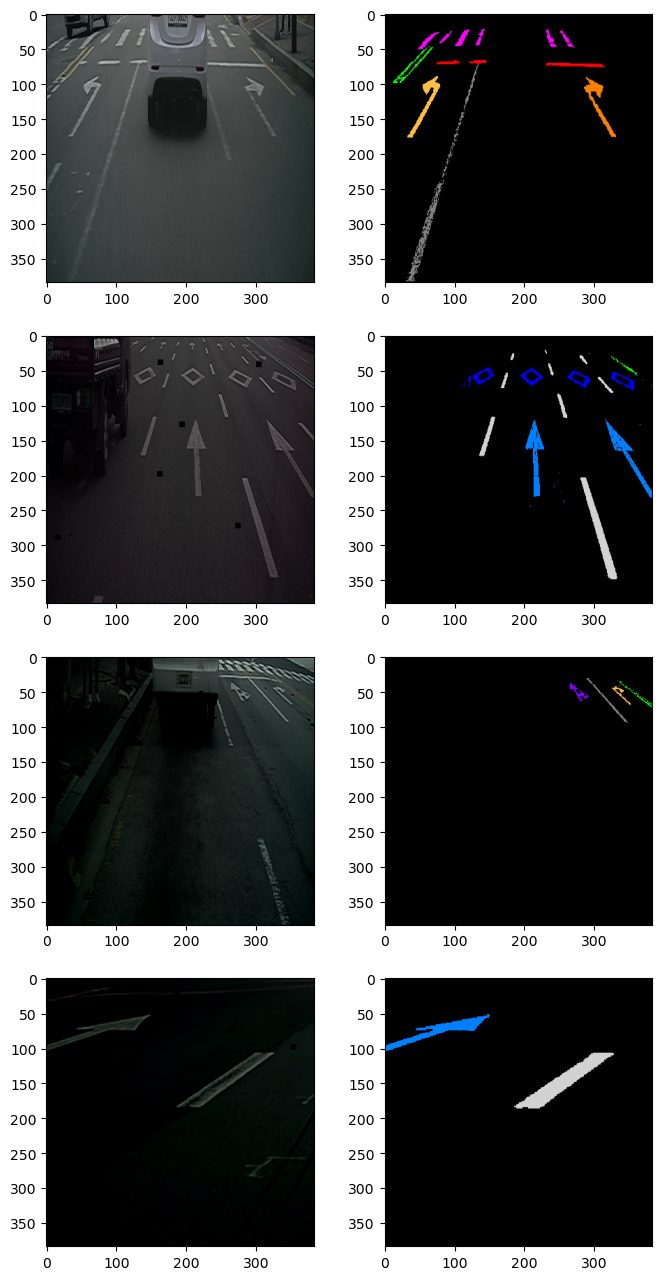

In [52]:
r, c = 4, 2
plt.figure(figsize=(r*2,c*8))
for e, i in enumerate(dataTrain):
    print(e)
    print(len(i))
    plt.subplot(r, c, 1)
    plt.imshow(i[0][0])
    plt.subplot(r, c, 2)
    plt.imshow(decode_one_hot_op(i[1][0], class_colors))
    plt.subplot(r, c, 3)
    plt.imshow(i[0][1])
    plt.subplot(r, c, 4)
    plt.imshow(decode_one_hot_op(i[1][1], class_colors))
    plt.subplot(r, c, 5)
    plt.imshow(i[0][2])
    plt.subplot(r, c, 6)
    plt.imshow(decode_one_hot_op(i[1][2], class_colors))
    plt.subplot(r, c, 7)
    plt.imshow(i[0][3])
    plt.subplot(r, c, 8)
    plt.imshow(decode_one_hot_op(i[1][3], class_colors))
    break